# Darcy equation

In this tutorial we present how to solve an evolutionary Darcy equation with [PyGeoN](https://github.com/compgeo-mox/pygeon).  The unkwons are the velocity $q$ and the pressure $p$.

Let $\Omega=(0,1)^2$ with boundary $\partial \Omega$ and outward unit normal ${\nu}$. Let $(0,T)$ with $10=T>0$ be the overall simulation period. Given 
$k$ the matrix permeability, we want to solve the following problem: find $({q}, p)$ such that
$$
\left\{
\begin{array}{ll}
\begin{array}{l} 
k^{-1} {q} + \nabla p = {- \rho g \nabla y}\\
p_t + \nabla \cdot {q} = f
\end{array}
&\text{in } \Omega \times (0,T)
\end{array}
\right.
$$
with boundary conditions:
$$ p = 0 \text{ on } \partial_{top} \Omega \times (0,T] \qquad p = \rho g \text{ on } \partial_{bottom} \Omega \times (0,T] \qquad \nu \cdot q = 0 \text{ on } \partial_{left} \Omega \cup \partial_{right} \Omega \times (0,T] $$
and initial conditions:
$$ p|_{t=0} = (1-y) \rho g \text{ in } \Omega \qquad q|_{t=0} = 0 \text{ in } \Omega $$

We present *step-by-step* how to create the grid, declare the problem data, and finally solve the problem.

First we import some of the standard modules, like `numpy` and `scipy.sparse`. Since PyGeoN is based on [PorePy](https://github.com/pmgbergen/porepy) we import both modules.

In [1]:
%load_ext Cython

In [2]:
import shutil
import os

import numpy as np
import scipy.sparse as sps
import scipy.integrate as integrate

import porepy as pp
import pygeon as pg

import sympy as sp

from math import ceil, floor, log10, exp

/opt/conda/lib/python3.11/site-packages/porepy/numerics/nonlinear/nonlinear_solvers.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange  # type: ignore


For a manual import:

import sys
sys.path.append('/path/to/repository')

In [3]:
from utilities.assembly_utilities import find_ordering, local_A, local_Mh, transoform_nodal_func_to_physical_element
from richards.model_params import Model_Data
from richards.plot_exporter import Plot_Exporter
from richards.csv_exporter import Csv_Exporter

### Parameters

In [4]:
# Set the maximum number of iterations of the non-linear solver
K = 500

# L-scheme parameter
L = 3.501e-2 #0.1

# Set the mesh refinment
N = 10

# Set the number of steps (excluding the initial condition)
num_steps = 27

quad_order = 3

# Simulation time length
T = num_steps/48

# Time switch conditions (for the boundary condition)
dt_D = 3/48

# Fluid density
rho = 1000

# Relative and absolute tolerances for the non-linear solver
abs_tol = 1e-10
rel_tol = 1e-5

# Domain tolerance
domain_tolerance = 1 / (10 * N)

# Output directory
output_directory = 'lagrange_hard_coupling'

In [5]:
def initial_h(x): return 1

In [6]:
# Van Genuchten model parameters ( relative permeability model )
model_data = Model_Data(theta_r=0.131, theta_s=0.396, alpha=0.423, n=2.06, K_s=4.96e-2, T=T, num_steps=num_steps)

In [7]:
# Time step
dt   = (T-0)/num_steps

### Mesh

In [8]:
bottom_grid =   pp.StructuredTriangleGrid([2*N, N], [2, 1])
bottom_grid.compute_geometry()

In [9]:
top_grid    = pp.StructuredTriangleGrid([2*N, 2*N], [2, 2])
top_grid.compute_geometry()

In [10]:
boundary_grid, boundary_face_map, boundary_node_map  = pp.partition.extract_subgrid(bottom_grid, 
                                                                                    bottom_grid.face_centers[1, :] == 1, 
                                                                                    faces=True)

### Discretization

In [11]:
key = "flow"

In [12]:
top_field = pg.Lagrange1(key)
top_data = {}

top_dof =  top_field.ndof( top_grid )

In [13]:
bottom_field = pg.Lagrange1(key)
bottom_data = {}

bottom_dof = bottom_field.ndof( bottom_grid )

In [14]:
boundary_field = pg.Lagrange1(key)
boundary_data = {}

boundary_dof = boundary_field.ndof( boundary_grid )

### Restrictor Matrices

In [15]:
bottom_delete_boundary_dof = np.zeros( shape=(bottom_dof - boundary_dof, bottom_dof) )
bottom_delete_boundary_dof[np.arange(bottom_dof - boundary_dof), bottom_grid.nodes[1, :] < 1] = 1
bottom_delete_boundary_dof = sps.csr_matrix(bottom_delete_boundary_dof)

In [16]:
bottom_isolate_boundary_dof = np.zeros(shape=(boundary_dof, bottom_dof))
bottom_isolate_boundary_dof[np.arange(boundary_dof), bottom_grid.nodes[1, :] == 1] = 1
bottom_isolate_boundary_dof = sps.csr_matrix(bottom_isolate_boundary_dof)

In [17]:
top_delete_boundary_dof = np.zeros( shape=(top_dof - boundary_dof, top_dof) )
top_delete_boundary_dof[np.arange(top_dof - boundary_dof), top_grid.nodes[1, :] > 0] = 1
top_delete_boundary_dof = sps.csr_matrix(top_delete_boundary_dof)

In [18]:
top_isolate_boundary_dof = np.zeros(shape=(boundary_dof, top_dof))
top_isolate_boundary_dof[np.arange(boundary_dof), top_grid.nodes[1, :] == 0] = 1
top_isolate_boundary_dof = sps.csr_matrix(top_isolate_boundary_dof)

### BCs

In [19]:
bot_dirichlet_flag  = np.array(np.logical_and( bottom_grid.nodes[0, :] == 2, bottom_grid.nodes[1, :] <= 1 ), dtype=bool)
bot_dirichlet_value = np.array(bot_dirichlet_flag, dtype=float)

In [20]:
top_dirichlet_flag  = np.array(np.logical_and( top_grid.nodes[1, :] == 2, top_grid.nodes[0, :] <= 1 ), dtype=bool)
top_dirichlet_value = lambda t: np.array(top_dirichlet_flag, dtype=float) * min( 6.2, 1 + 5.2 * t / dt_D )

In [21]:
dirichlet_flag  = np.hstack(( bot_dirichlet_flag, top_dirichlet_flag, np.zeros(shape=boundary_dof, dtype=bool)))
dirichlet_value = lambda t: np.hstack(( bot_dirichlet_value, top_dirichlet_value(t), np.zeros(shape=boundary_dof, dtype=bool)))

### Matrix Assembly

##### Projection matrices

In [22]:
top_proj    = top_field.eval_at_cell_centers( top_grid )
bottom_proj = bottom_field.eval_at_cell_centers( bottom_grid )

##### Stifness

In [23]:
def bottom_stifness_gen():
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix

        A = local_A(coord_loc, lambda x,y: model_data.K_s * np.eye(2), quad_order)
        
        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [24]:
def top_stifness_gen(h_dofs):
    size = np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix

        h_func = transoform_nodal_func_to_physical_element(h_dofs[nodes_loc], coord_loc)
        A = local_A(coord_loc, lambda x,y: model_data.hydraulic_conductivity_coefficient(h_func(x,y), 1+y) * np.eye(2), quad_order)
        
        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

##### Mass

In [25]:
def bottom_mass_gen():
    size = np.power(bottom_grid.dim + 1, 2) * bottom_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_Mh(coord_loc, lambda x,y: 1, quad_order)

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

In [26]:
def top_mass_gen():
    size = np.power(top_grid.dim + 1, 2) * top_grid.num_cells
    rows_I = np.empty(size, dtype=int)
    cols_J = np.empty(size, dtype=int)
    data_IJ = np.empty(size)
    idx = 0

    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        # Compute the stiff-H1 local matrix
        A = local_Mh(coord_loc, lambda x,y: 1, quad_order)

        # Save values for stiff-H1 local matrix in the global structure
        cols = np.tile(nodes_loc, (nodes_loc.size, 1))

        loc_idx = slice(idx, idx + cols.size)
        rows_I[loc_idx] = cols.T.ravel()
        cols_J[loc_idx] = cols.ravel()
        data_IJ[loc_idx] = A.ravel()
        idx += cols.size

    # Construct the global matrices
    return sps.csc_matrix((data_IJ, (rows_I, cols_J)))

### Solving stage

In [27]:
if os.path.exists(output_directory):
    shutil.rmtree(output_directory)

In [28]:
# assemble initial solution
initial_solution = np.zeros(top_dof + bottom_dof + boundary_dof)

In [29]:
bottom_mask = np.zeros_like(initial_solution, dtype=bool)
bottom_mask[ : (bottom_dof) ] = True

top_mask = np.zeros_like(initial_solution, dtype=bool)
top_mask[(bottom_dof) : (bottom_dof + top_dof)] = True

lambda_mask = np.zeros_like(bottom_mask, dtype=bool)
lambda_mask[(bottom_dof + top_dof):] = True

In [30]:
initial_solution[top_mask]    =    top_field.interpolate(   top_grid, lambda x: 1)
initial_solution[bottom_mask] = bottom_field.interpolate(bottom_grid, lambda x: 1)

In [31]:
top_saver    = pp.Exporter(top_grid,    "top_sol", folder_name=output_directory)
bottom_saver = pp.Exporter(bottom_grid, "bottom_sol", folder_name=output_directory)
plot_exp = Plot_Exporter(output_directory)

def save_step(current_sol, step):
    ins = list()

    ins.append((top_grid, "cell_h", top_proj @ current_sol[top_mask]))
    ins.append((top_grid, "cell_p", top_proj @ (current_sol[top_mask] - 1 - top_grid.nodes[1, :])))
    top_saver.write_vtu(ins, time_step=step)

    ins = list()

    ins.append((bottom_grid, "cell_h", bottom_proj @ current_sol[bottom_mask]))
    ins.append((bottom_grid, "cell_p", bottom_proj @ (current_sol[bottom_mask] - bottom_grid.nodes[1, :])))
    bottom_saver.write_vtu(ins, time_step=step)

    exporter = Csv_Exporter(os.path.join(output_directory, 'csv'), str(step) + '.csv', ['x', 'y', 'h', 'p'])

    xs = []
    ys = []
    hs = []

    tmp = np.hstack([current_sol[:(bottom_dof-boundary_dof)], current_sol[bottom_dof:(bottom_dof + top_dof)]])
    for x,y,h,p in zip(np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[0, :], top_grid.nodes[0, :]]),
                       np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1]),
                       tmp,
                       tmp - np.hstack([bottom_delete_boundary_dof @ bottom_grid.nodes[1, :], top_grid.nodes[1, :]+1])):
        xs.append(x)
        ys.append(y)
        hs.append(h)

        exporter.add_entry([x,y,h,p])

    plot_exp.export_surface(np.array(xs), np.array(ys), np.array(hs), str(step), shape_x=2*N+1, shape_y=3*N+1, show=True)

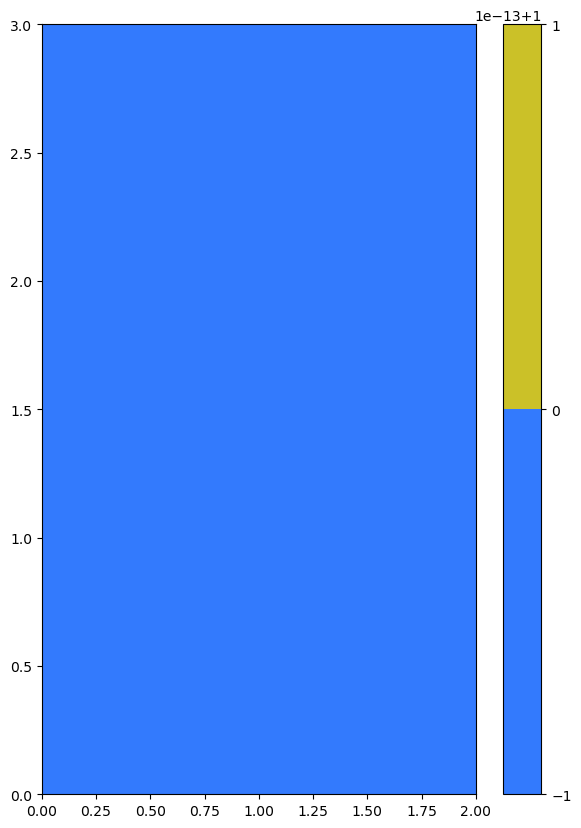

In [32]:
# solve the problem

sol = [initial_solution]

t = 0

save_step(sol[-1], 0)

In [33]:
def bottom_normal_continuity_matrix():
    data = []
    cols = []
    rows = []
    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(bottom_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = bottom_grid.cell_nodes()

    for c in np.arange(bottom_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        if np.abs(np.max(coord_loc[1, :]) - 1) < 1e-7:
            
            ordering, m = find_ordering(coord_loc)

            if m < 0:
                eta_cell = np.max(np.where( boundary_grid.nodes[0, :] < bottom_grid.cell_centers[0, c] ))

                ordered_coords = coord_loc[:, ordering]

                x0 = ordered_coords[:, 0]
                x1 = ordered_coords[:, 1]
                x2 = ordered_coords[:, 2]
                
                q_funcs = [model_data.K_s * np.array([-1/(x2[0] - x0[0]), -1/(x1[1] - x0[1])]), 
                           model_data.K_s * np.array([                 0,  1/(x1[1] - x0[1])]), 
                           model_data.K_s * np.array([ 1/(x2[0] - x0[0]),                  0])]
            
                for i in range(3):
                    rows.append(eta_cell)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

                    rows.append(eta_cell+1)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

    
    return sps.coo_matrix((np.array(data), (np.array(rows), np.array(cols))), shape=(boundary_dof, bottom_grid.num_nodes))

In [34]:
def top_normal_continuity_matrix(h_dofs):
    data = []
    cols = []
    rows = []
    _, _, _, _, _, node_coords = pp.map_geometry.map_grid(top_grid)

    # Allocate the data to store matrix entries, that's the most efficient
    # way to create a sparse matrix.

    cell_nodes = top_grid.cell_nodes()

    for c in np.arange(top_grid.num_cells):
        # For the current cell retrieve its nodes
        loc = slice(cell_nodes.indptr[c], cell_nodes.indptr[c + 1])

        nodes_loc = cell_nodes.indices[loc]
        coord_loc = node_coords[:, nodes_loc]

        if np.abs(np.min(coord_loc[1, :]) - 0) < 1e-7:
            ordering, m = find_ordering(coord_loc)

            if m > 0:
                eta_cell = np.max(np.where( boundary_grid.nodes[0, :] < top_grid.cell_centers[0, c] ))

                ordered_coords = coord_loc[:, ordering]

                h_ord = h_dofs[nodes_loc][ordering]

                x0 = ordered_coords[:, 0]
                x1 = ordered_coords[:, 1]
                x2 = ordered_coords[:, 2]

                h_mean = (h_ord[0] + h_ord[2]) / 2

                q_funcs = [model_data.hydraulic_conductivity_coefficient(h_mean, 1) * np.array([-1/(x2[0] - x0[0]), -1/(x1[1] - x0[1])]), 
                           model_data.hydraulic_conductivity_coefficient(h_mean, 1) * np.array([                 0,  1/(x1[1] - x0[1])]), 
                           model_data.hydraulic_conductivity_coefficient(h_mean, 1) * np.array([ 1/(x2[0] - x0[0]),                  0])]
            
                for i in range(3):
                    rows.append(eta_cell)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

                    rows.append(eta_cell+1)
                    cols.append(nodes_loc[ ordering[i] ])
                    data.append(q_funcs[i].T @ np.array([0, 1]) * (x2[0] - x0[0]) / 2)

    
    return sps.coo_matrix((np.array(data), (np.array(rows), np.array(cols))), shape=(boundary_dof, top_grid.num_nodes))

In [35]:
top_mass = top_mass_gen()
bottom_mass_gen = bottom_mass_gen()

In [36]:
bottom_stifness = bottom_stifness_gen()

Time 0.02083
Iteration #0001, error L2 relative psi:    0.22415763028415


<lambdifygenerated-1>:2: RuntimeWarning: invalid value encountered in power
  return select([less(h, z),True], [0.265*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.514563106796116) + 0.131,0.396], default=nan)
<lambdifygenerated-2>:2: RuntimeWarning: invalid value encountered in scalar power
  return select([less(h, z),True], [0.0496*(1 - (1 - 1.0*(0.1699265174169*(-h + z)**2.06 + 1)**(-1.0))**0.514563106796116)**2*(0.1699265174169*(-h + z)**2.06 + 1)**(-0.257281553398058),0.0496], default=nan)


Iteration #0002, error L2 relative psi:    0.06758808902934
Iteration #0003, error L2 relative psi:    0.00997362911640
Iteration #0004, error L2 relative psi:    0.00066183446107
Iteration #0005, error L2 relative psi:    0.00012190875545
Iteration #0006, error L2 relative psi:    0.00001767509077
Iteration #0007, error L2 relative psi:    0.00000145205176


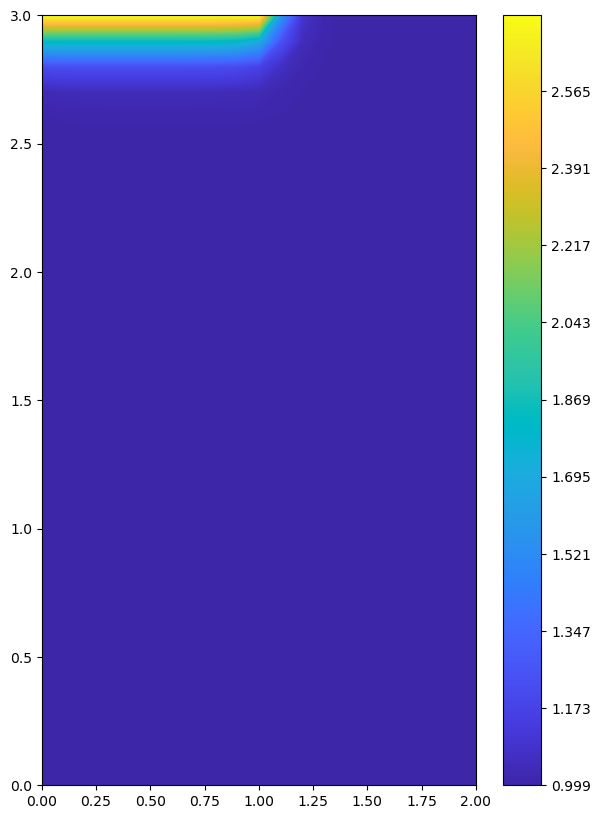


Time 0.04167
Iteration #0001, error L2 relative psi:    0.26932303242007
Iteration #0002, error L2 relative psi:    0.08646507190425
Iteration #0003, error L2 relative psi:    0.02853812874269
Iteration #0004, error L2 relative psi:    0.00643939745474
Iteration #0005, error L2 relative psi:    0.00239910829189
Iteration #0006, error L2 relative psi:    0.00073913629059
Iteration #0007, error L2 relative psi:    0.00016844750105
Iteration #0008, error L2 relative psi:    0.00005988589258
Iteration #0009, error L2 relative psi:    0.00001545765651
Iteration #0010, error L2 relative psi:    0.00000446892674


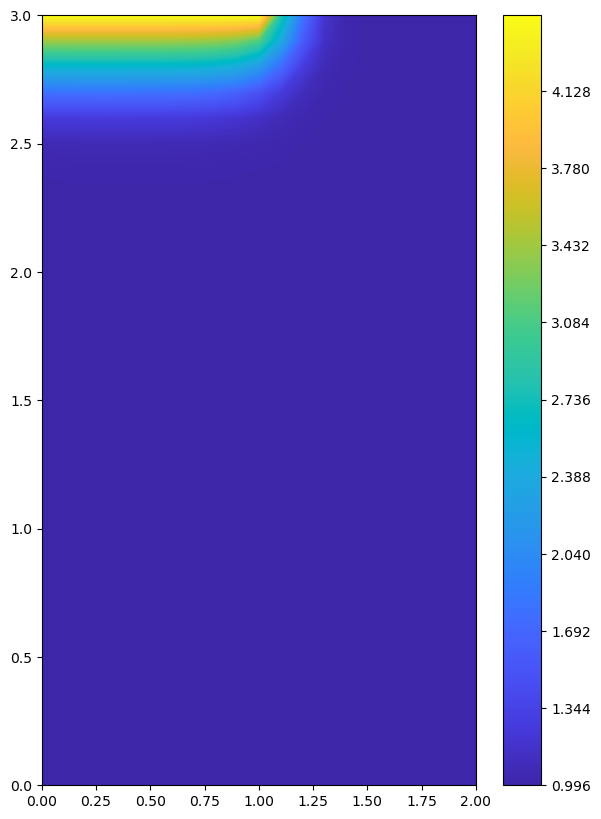


Time 0.0625
Iteration #0001, error L2 relative psi:    0.27586053717882
Iteration #0002, error L2 relative psi:    0.06781000142097
Iteration #0003, error L2 relative psi:    0.02484421051935
Iteration #0004, error L2 relative psi:    0.00779350292356
Iteration #0005, error L2 relative psi:    0.00215011154808
Iteration #0006, error L2 relative psi:    0.00064970996107
Iteration #0007, error L2 relative psi:    0.00027776569641
Iteration #0008, error L2 relative psi:    0.00012570895515
Iteration #0009, error L2 relative psi:    0.00005335438963
Iteration #0010, error L2 relative psi:    0.00002153859113
Iteration #0011, error L2 relative psi:    0.00000864551584


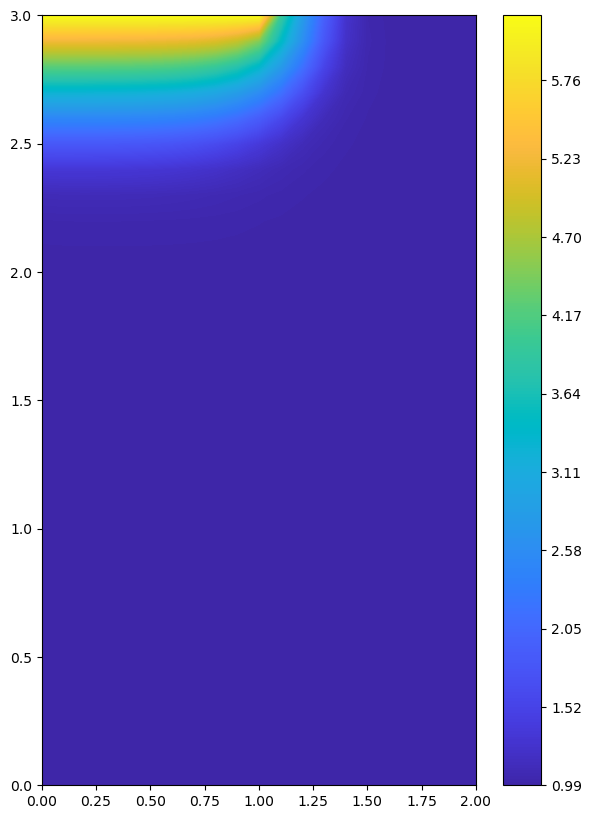


Time 0.08333
Iteration #0001, error L2 relative psi:    0.08997201472411
Iteration #0002, error L2 relative psi:    0.03309142587056
Iteration #0003, error L2 relative psi:    0.01484364976592
Iteration #0004, error L2 relative psi:    0.00730130499146
Iteration #0005, error L2 relative psi:    0.00396998090811
Iteration #0006, error L2 relative psi:    0.00228985425003
Iteration #0007, error L2 relative psi:    0.00134356348215
Iteration #0008, error L2 relative psi:    0.00078989580199
Iteration #0009, error L2 relative psi:    0.00046449013704
Iteration #0010, error L2 relative psi:    0.00027328087293
Iteration #0011, error L2 relative psi:    0.00016084323219
Iteration #0012, error L2 relative psi:    0.00009467567990
Iteration #0013, error L2 relative psi:    0.00005573445966
Iteration #0014, error L2 relative psi:    0.00003281603308
Iteration #0015, error L2 relative psi:    0.00001932374997
Iteration #0016, error L2 relative psi:    0.00001137889454
Iteration #0017, error L2 

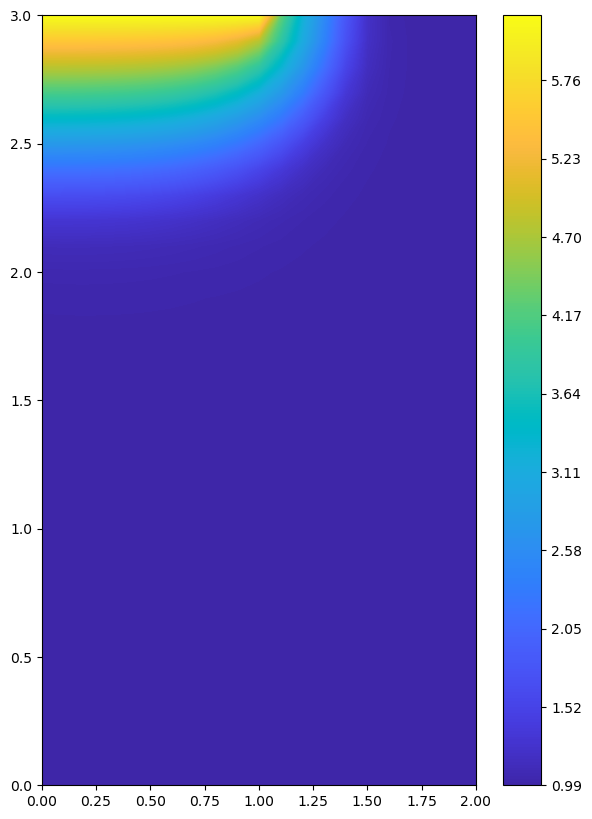


Time 0.10417
Iteration #0001, error L2 relative psi:    0.05968002852024
Iteration #0002, error L2 relative psi:    0.02169228972912
Iteration #0003, error L2 relative psi:    0.01134499832665
Iteration #0004, error L2 relative psi:    0.00694510654982
Iteration #0005, error L2 relative psi:    0.00458445274331
Iteration #0006, error L2 relative psi:    0.00311730657353
Iteration #0007, error L2 relative psi:    0.00214344371038
Iteration #0008, error L2 relative psi:    0.00148079753639
Iteration #0009, error L2 relative psi:    0.00102585170761
Iteration #0010, error L2 relative psi:    0.00071184768764
Iteration #0011, error L2 relative psi:    0.00049440687362
Iteration #0012, error L2 relative psi:    0.00034354879010
Iteration #0013, error L2 relative psi:    0.00023878234711
Iteration #0014, error L2 relative psi:    0.00016599322337
Iteration #0015, error L2 relative psi:    0.00011542182194
Iteration #0016, error L2 relative psi:    0.00008027071630
Iteration #0017, error L2 

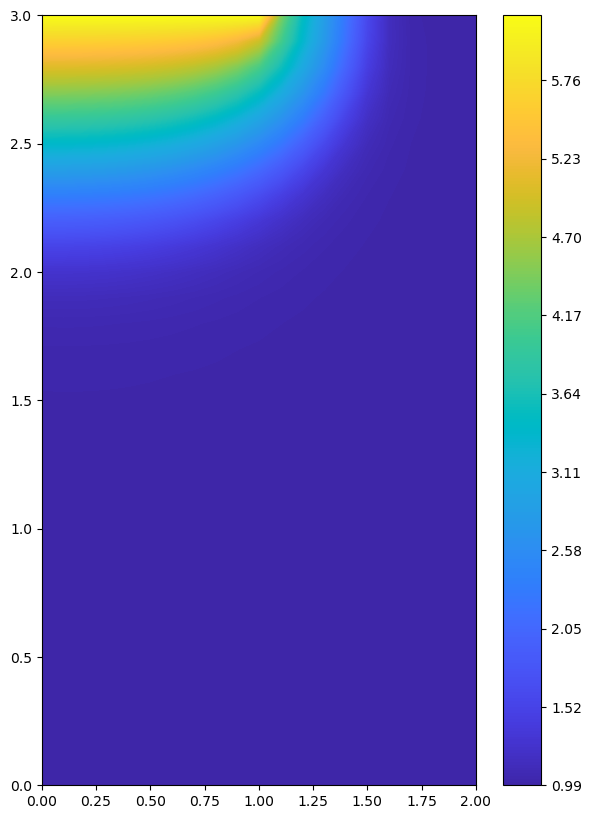


Time 0.125
Iteration #0001, error L2 relative psi:    0.04446840782996
Iteration #0002, error L2 relative psi:    0.01640104283074
Iteration #0003, error L2 relative psi:    0.00950624993461
Iteration #0004, error L2 relative psi:    0.00646027266689
Iteration #0005, error L2 relative psi:    0.00468581433528
Iteration #0006, error L2 relative psi:    0.00348915548255
Iteration #0007, error L2 relative psi:    0.00262985661691
Iteration #0008, error L2 relative psi:    0.00199488007089
Iteration #0009, error L2 relative psi:    0.00151890428265
Iteration #0010, error L2 relative psi:    0.00115908223041
Iteration #0011, error L2 relative psi:    0.00088565574945
Iteration #0012, error L2 relative psi:    0.00067736221051
Iteration #0013, error L2 relative psi:    0.00051849037212
Iteration #0014, error L2 relative psi:    0.00039708916498
Iteration #0015, error L2 relative psi:    0.00030421506521
Iteration #0016, error L2 relative psi:    0.00023310858723
Iteration #0017, error L2 re

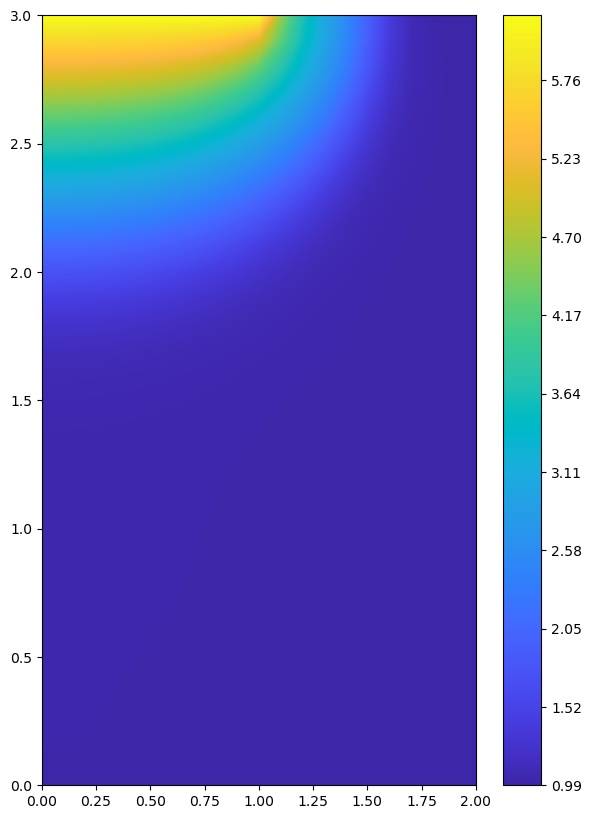


Time 0.14583
Iteration #0001, error L2 relative psi:    0.03496500178495
Iteration #0002, error L2 relative psi:    0.01365136857370
Iteration #0003, error L2 relative psi:    0.00865626831048
Iteration #0004, error L2 relative psi:    0.00633763644583
Iteration #0005, error L2 relative psi:    0.00492355806893
Iteration #0006, error L2 relative psi:    0.00392757174919
Iteration #0007, error L2 relative psi:    0.00317519917806
Iteration #0008, error L2 relative psi:    0.00258579774194
Iteration #0009, error L2 relative psi:    0.00211521569451
Iteration #0010, error L2 relative psi:    0.00173507157263
Iteration #0011, error L2 relative psi:    0.00142626550356
Iteration #0012, error L2 relative psi:    0.00117435467751
Iteration #0013, error L2 relative psi:    0.00096817863540
Iteration #0014, error L2 relative psi:    0.00079895304773
Iteration #0015, error L2 relative psi:    0.00065980535303
Iteration #0016, error L2 relative psi:    0.00054521458957
Iteration #0017, error L2 

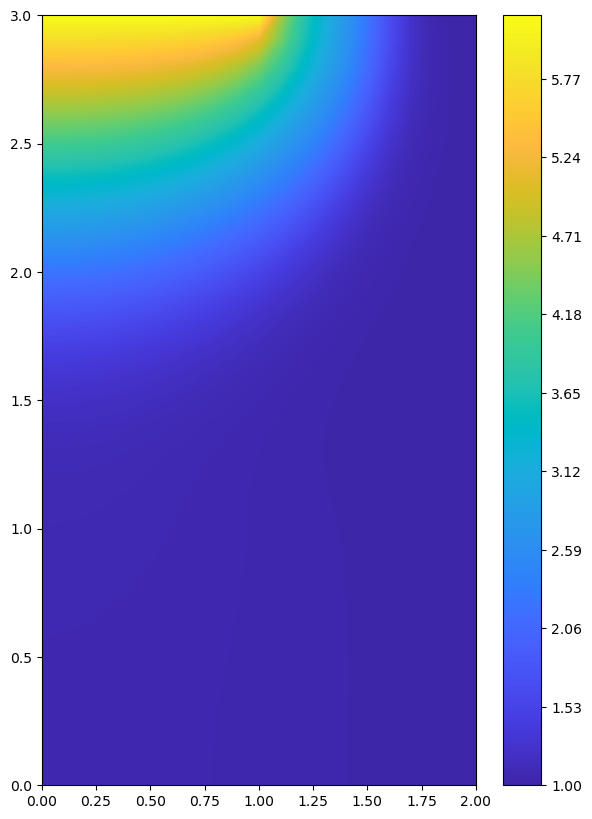


Time 0.16667
Iteration #0001, error L2 relative psi:    0.02831078225108
Iteration #0002, error L2 relative psi:    0.01240485523305
Iteration #0003, error L2 relative psi:    0.00929211309857
Iteration #0004, error L2 relative psi:    0.00783445139633
Iteration #0005, error L2 relative psi:    0.00690224105974
Iteration #0006, error L2 relative psi:    0.00619542017950
Iteration #0007, error L2 relative psi:    0.00561295988504
Iteration #0008, error L2 relative psi:    0.00510876219969
Iteration #0009, error L2 relative psi:    0.00466108482606
Iteration #0010, error L2 relative psi:    0.00426073921047
Iteration #0011, error L2 relative psi:    0.00390170245406
Iteration #0012, error L2 relative psi:    0.00357878245483
Iteration #0013, error L2 relative psi:    0.00328732522295
Iteration #0014, error L2 relative psi:    0.00302311629566
Iteration #0015, error L2 relative psi:    0.00278292623089
Iteration #0016, error L2 relative psi:    0.00256411739081
Iteration #0017, error L2 

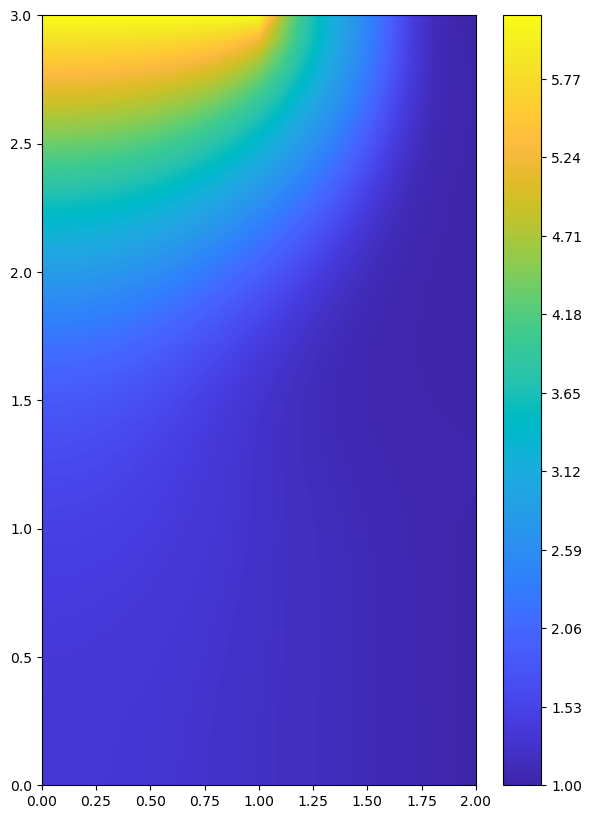


Time 0.1875
Iteration #0001, error L2 relative psi:    0.02279982534552
Iteration #0002, error L2 relative psi:    0.01042232227052
Iteration #0003, error L2 relative psi:    0.00871804957567
Iteration #0004, error L2 relative psi:    0.00795115130447
Iteration #0005, error L2 relative psi:    0.00739919494634
Iteration #0006, error L2 relative psi:    0.00691850448810
Iteration #0007, error L2 relative psi:    0.00647689161483
Iteration #0008, error L2 relative psi:    0.00606547018211
Iteration #0009, error L2 relative psi:    0.00568153923433
Iteration #0010, error L2 relative psi:    0.00532370169592
Iteration #0011, error L2 relative psi:    0.00499038136193
Iteration #0012, error L2 relative psi:    0.00467989133834
Iteration #0013, error L2 relative psi:    0.00439064389439
Iteration #0014, error L2 relative psi:    0.00412105859830
Iteration #0015, error L2 relative psi:    0.00386962059726
Iteration #0016, error L2 relative psi:    0.00363495945468
Iteration #0017, error L2 r

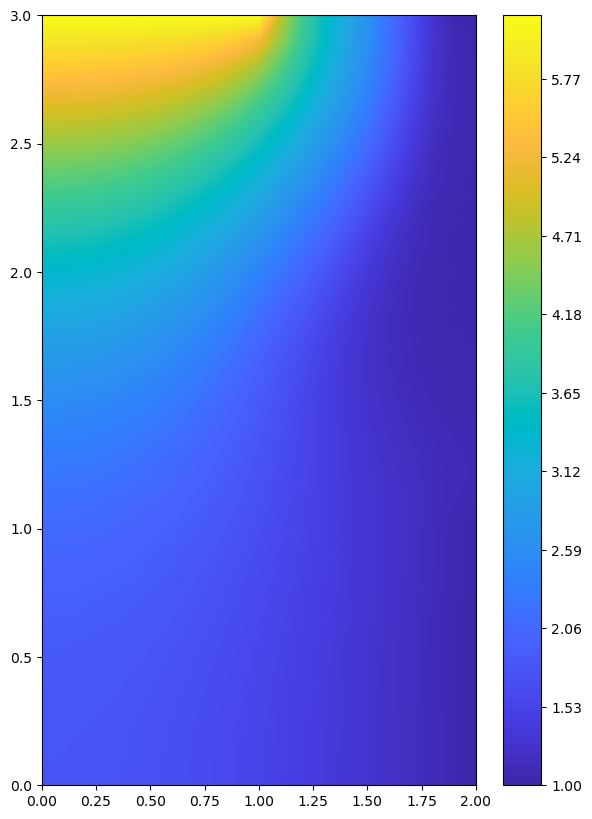


Time 0.20833
Iteration #0001, error L2 relative psi:    0.01914678374653
Iteration #0002, error L2 relative psi:    0.00713157883722
Iteration #0003, error L2 relative psi:    0.00511712982121
Iteration #0004, error L2 relative psi:    0.00419385500089
Iteration #0005, error L2 relative psi:    0.00364154506465
Iteration #0006, error L2 relative psi:    0.00325597196042
Iteration #0007, error L2 relative psi:    0.00296447924889
Iteration #0008, error L2 relative psi:    0.00273213842301
Iteration #0009, error L2 relative psi:    0.00253958393702
Iteration #0010, error L2 relative psi:    0.00237497125395
Iteration #0011, error L2 relative psi:    0.00223060495857
Iteration #0012, error L2 relative psi:    0.00210140838013
Iteration #0013, error L2 relative psi:    0.00198395079964
Iteration #0014, error L2 relative psi:    0.00187589950462
Iteration #0015, error L2 relative psi:    0.00177564221915
Iteration #0016, error L2 relative psi:    0.00168202578961
Iteration #0017, error L2 

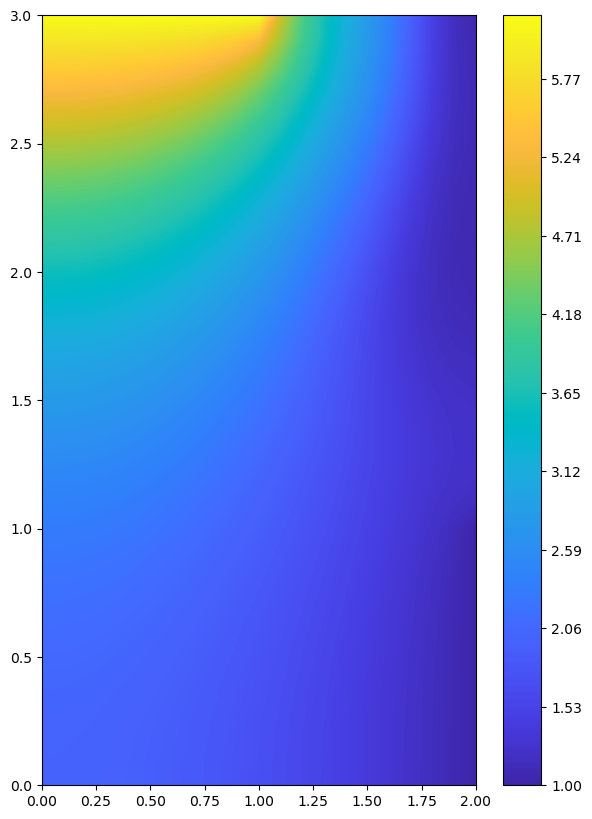


Time 0.22917
Iteration #0001, error L2 relative psi:    0.01752512035218
Iteration #0002, error L2 relative psi:    0.00562754448774
Iteration #0003, error L2 relative psi:    0.00380100714636
Iteration #0004, error L2 relative psi:    0.00298223923391
Iteration #0005, error L2 relative psi:    0.00251057420064
Iteration #0006, error L2 relative psi:    0.00219331475455
Iteration #0007, error L2 relative psi:    0.00196127317766
Iteration #0008, error L2 relative psi:    0.00178257868216
Iteration #0009, error L2 relative psi:    0.00163981083867
Iteration #0010, error L2 relative psi:    0.00152234227743
Iteration #0011, error L2 relative psi:    0.00142319529379
Iteration #0012, error L2 relative psi:    0.00133758049403
Iteration #0013, error L2 relative psi:    0.00126214103857
Iteration #0014, error L2 relative psi:    0.00119450213420
Iteration #0015, error L2 relative psi:    0.00113297165309
Iteration #0016, error L2 relative psi:    0.00107633595830
Iteration #0017, error L2 

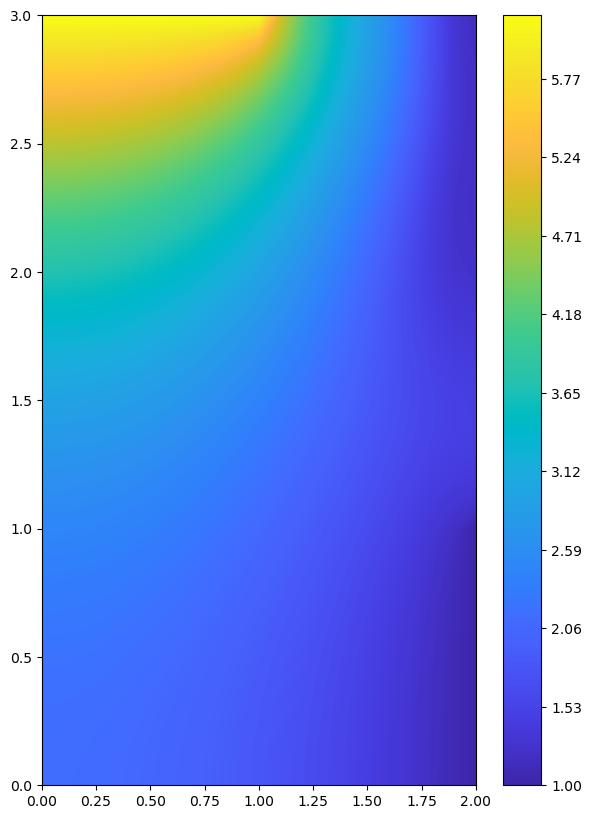


Time 0.25
Iteration #0001, error L2 relative psi:    0.01727620027661
Iteration #0002, error L2 relative psi:    0.00539524090733
Iteration #0003, error L2 relative psi:    0.00362111457233
Iteration #0004, error L2 relative psi:    0.00283464306238
Iteration #0005, error L2 relative psi:    0.00237784238607
Iteration #0006, error L2 relative psi:    0.00207013528371
Iteration #0007, error L2 relative psi:    0.00184453235034
Iteration #0008, error L2 relative psi:    0.00167037085461
Iteration #0009, error L2 relative psi:    0.00153113433201
Iteration #0010, error L2 relative psi:    0.00141681217166
Iteration #0011, error L2 relative psi:    0.00132084847234
Iteration #0012, error L2 relative psi:    0.00123879079485
Iteration #0013, error L2 relative psi:    0.00116741494492
Iteration #0014, error L2 relative psi:    0.00110434268889
Iteration #0015, error L2 relative psi:    0.00104781751312
Iteration #0016, error L2 relative psi:    0.00099652055281
Iteration #0017, error L2 rel

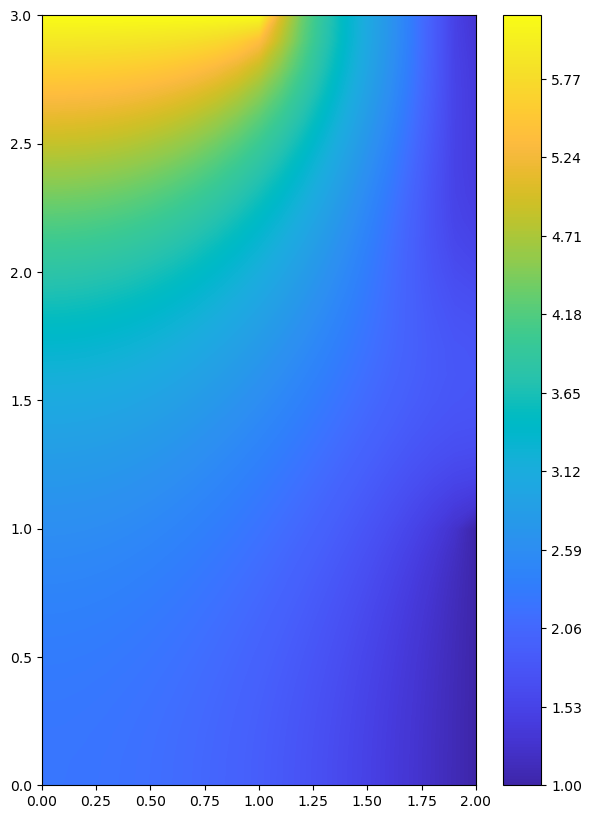


Time 0.27083
Iteration #0001, error L2 relative psi:    0.01719029599339
Iteration #0002, error L2 relative psi:    0.00607051207463
Iteration #0003, error L2 relative psi:    0.00416773015732
Iteration #0004, error L2 relative psi:    0.00331491216711
Iteration #0005, error L2 relative psi:    0.00280367169522
Iteration #0006, error L2 relative psi:    0.00245311297564
Iteration #0007, error L2 relative psi:    0.00219289287804
Iteration #0008, error L2 relative psi:    0.00198985230054
Iteration #0009, error L2 relative psi:    0.00182628044443
Iteration #0010, error L2 relative psi:    0.00169126593314
Iteration #0011, error L2 relative psi:    0.00157772010354
Iteration #0012, error L2 relative psi:    0.00148064202535
Iteration #0013, error L2 relative psi:    0.00139641806949
Iteration #0014, error L2 relative psi:    0.00132238662102
Iteration #0015, error L2 relative psi:    0.00125654549665
Iteration #0016, error L2 relative psi:    0.00119729840625
Iteration #0017, error L2 

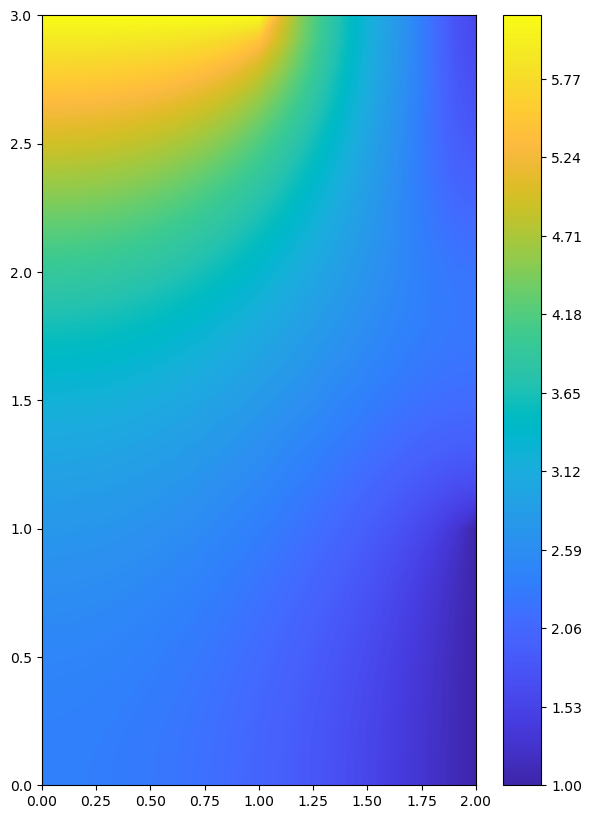


Time 0.29167
Iteration #0001, error L2 relative psi:    0.01610569123024
Iteration #0002, error L2 relative psi:    0.00700033114939
Iteration #0003, error L2 relative psi:    0.00500572311241
Iteration #0004, error L2 relative psi:    0.00406224315872
Iteration #0005, error L2 relative psi:    0.00347574491781
Iteration #0006, error L2 relative psi:    0.00305987090523
Iteration #0007, error L2 relative psi:    0.00274496771435
Iteration #0008, error L2 relative psi:    0.00249624654230
Iteration #0009, error L2 relative psi:    0.00229381357315
Iteration #0010, error L2 relative psi:    0.00212510906802
Iteration #0011, error L2 relative psi:    0.00198214482687
Iteration #0012, error L2 relative psi:    0.00185939658543
Iteration #0013, error L2 relative psi:    0.00175279355393
Iteration #0014, error L2 relative psi:    0.00165931437130
Iteration #0015, error L2 relative psi:    0.00157659998658
Iteration #0016, error L2 relative psi:    0.00150272660153
Iteration #0017, error L2 

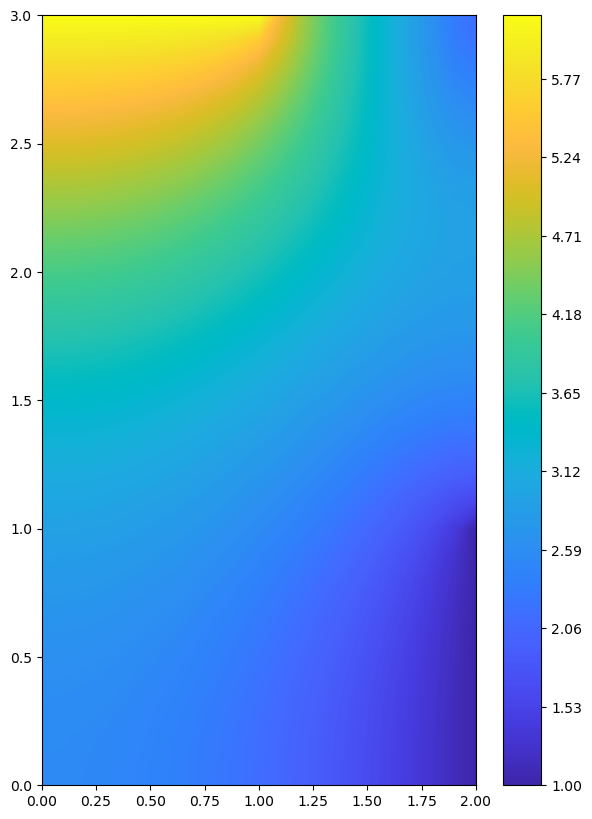


Time 0.3125
Iteration #0001, error L2 relative psi:    0.01365827839599
Iteration #0002, error L2 relative psi:    0.00824128415046
Iteration #0003, error L2 relative psi:    0.00657808952414
Iteration #0004, error L2 relative psi:    0.00569657596921
Iteration #0005, error L2 relative psi:    0.00509406247655
Iteration #0006, error L2 relative psi:    0.00463025588168
Iteration #0007, error L2 relative psi:    0.00425055244788
Iteration #0008, error L2 relative psi:    0.00393030833707
Iteration #0009, error L2 relative psi:    0.00365538670247
Iteration #0010, error L2 relative psi:    0.00341627874360
Iteration #0011, error L2 relative psi:    0.00320623320887
Iteration #0012, error L2 relative psi:    0.00302025184957
Iteration #0013, error L2 relative psi:    0.00285450300762
Iteration #0014, error L2 relative psi:    0.00270596281099
Iteration #0015, error L2 relative psi:    0.00257218718981
Iteration #0016, error L2 relative psi:    0.00245116222956
Iteration #0017, error L2 r

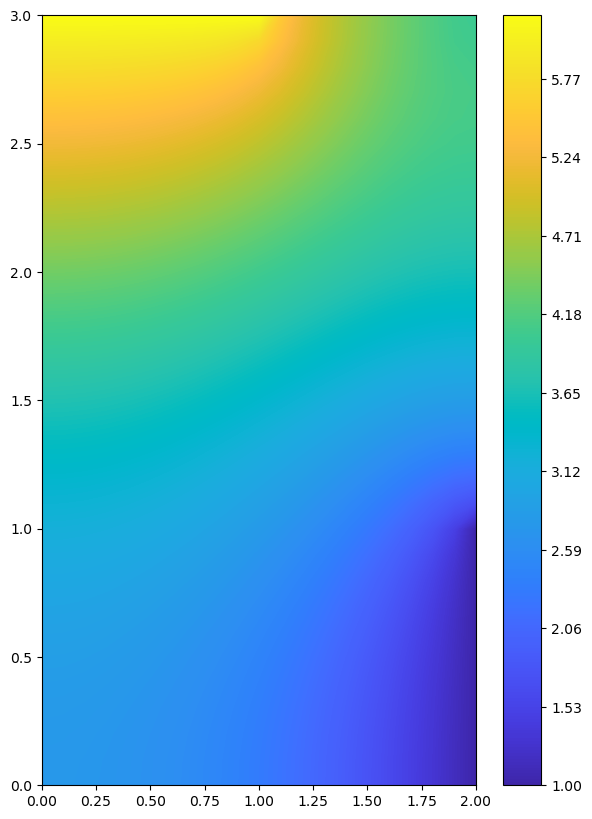


Time 0.33333
Iteration #0001, error L2 relative psi:    0.00306375556567
Iteration #0002, error L2 relative psi:    0.00201234305690
Iteration #0003, error L2 relative psi:    0.00156490178314
Iteration #0004, error L2 relative psi:    0.00131171070123
Iteration #0005, error L2 relative psi:    0.00114353582620
Iteration #0006, error L2 relative psi:    0.00102045979969
Iteration #0007, error L2 relative psi:    0.00092464173993
Iteration #0008, error L2 relative psi:    0.00084691620375
Iteration #0009, error L2 relative psi:    0.00078205775233
Iteration #0010, error L2 relative psi:    0.00072683427366
Iteration #0011, error L2 relative psi:    0.00067911142844
Iteration #0012, error L2 relative psi:    0.00063740231601
Iteration #0013, error L2 relative psi:    0.00060062403323
Iteration #0014, error L2 relative psi:    0.00056795805848
Iteration #0015, error L2 relative psi:    0.00053876620827
Iteration #0016, error L2 relative psi:    0.00051253797780
Iteration #0017, error L2 

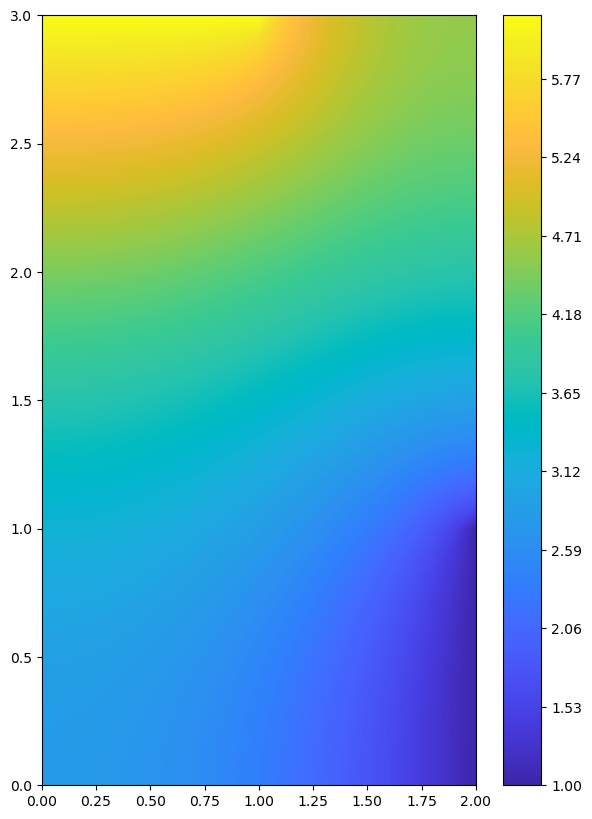


Time 0.35417
Iteration #0001, error L2 relative psi:    0.00000962874098


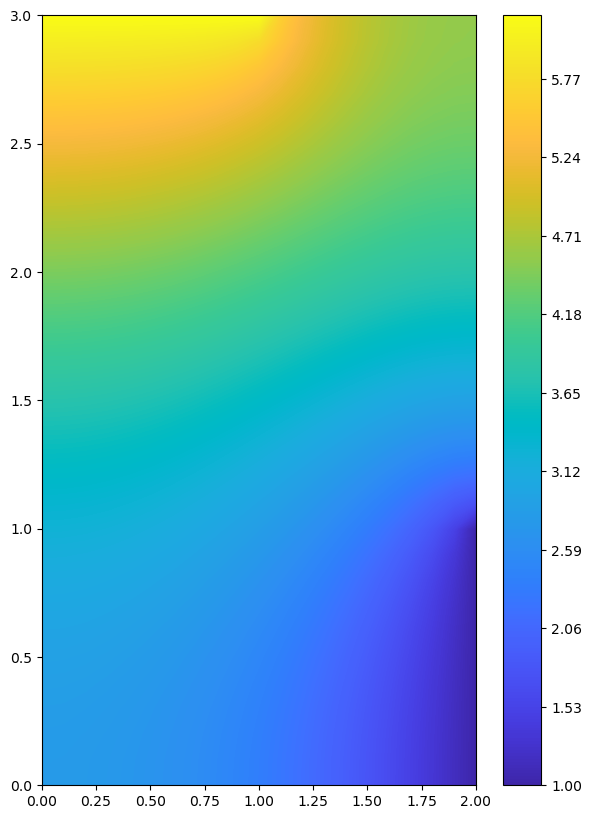


Time 0.375
Iteration #0001, error L2 relative psi:    0.00000937498790


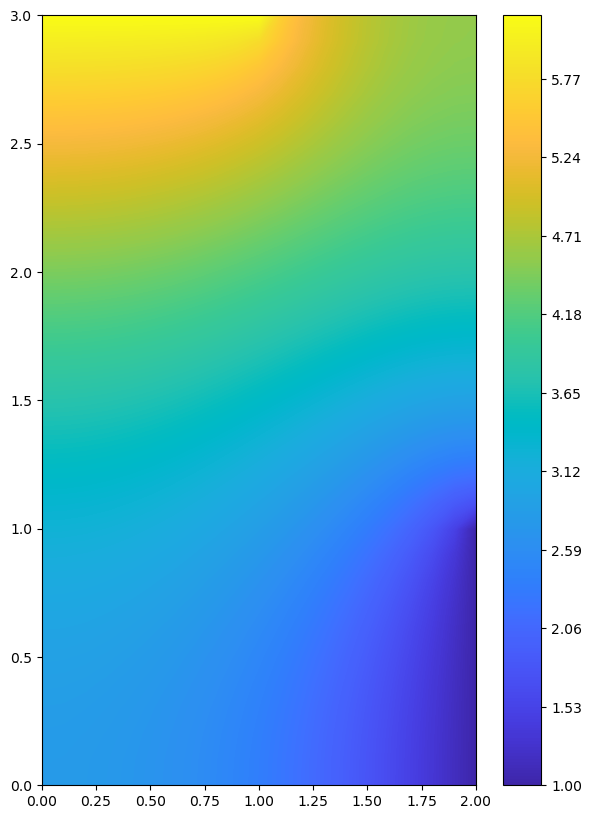


Time 0.39583
Iteration #0001, error L2 relative psi:    0.00000912792317


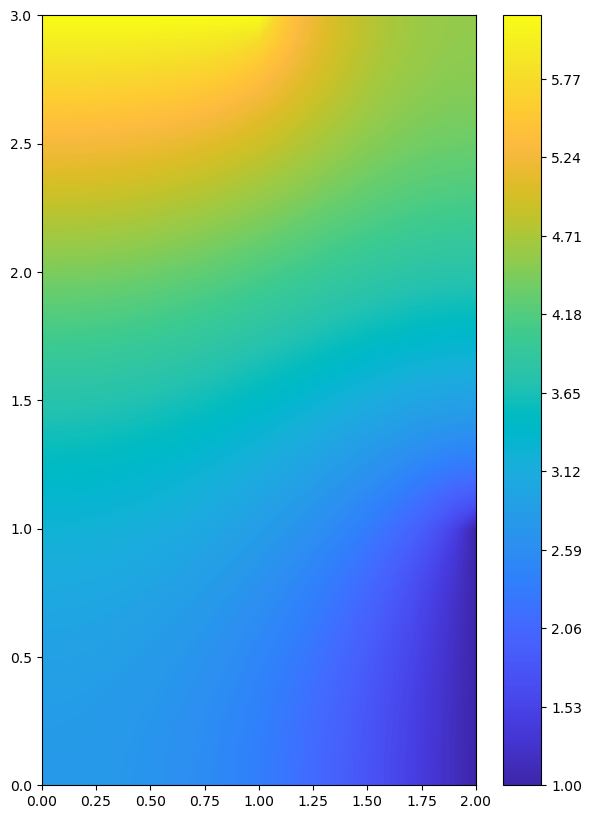


Time 0.41667
Iteration #0001, error L2 relative psi:    0.00000888737048


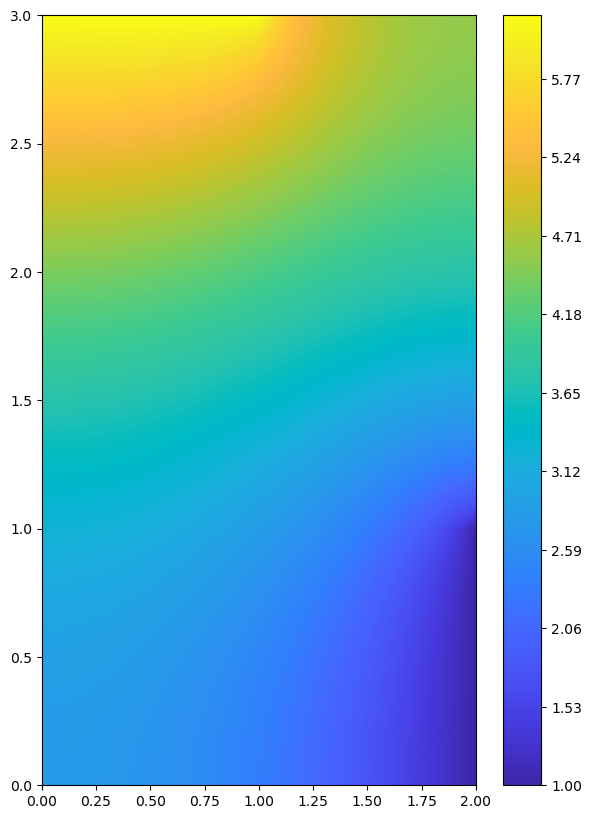


Time 0.4375
Iteration #0001, error L2 relative psi:    0.00000865315817


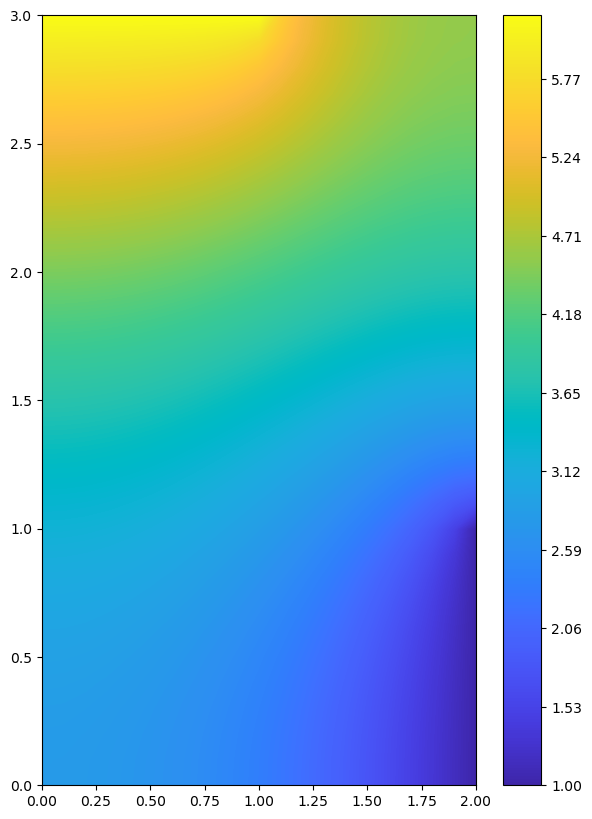


Time 0.45833
Iteration #0001, error L2 relative psi:    0.00000842511910


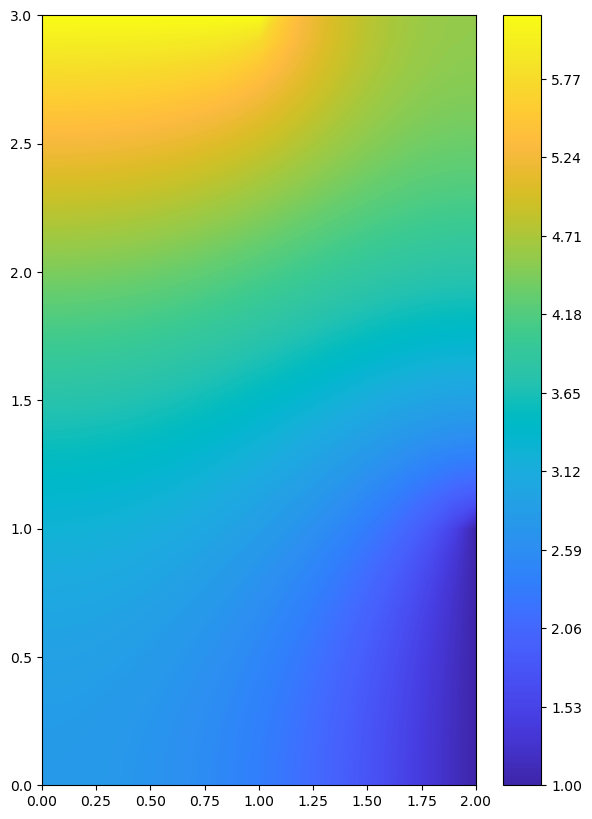


Time 0.47917
Iteration #0001, error L2 relative psi:    0.00000820309052


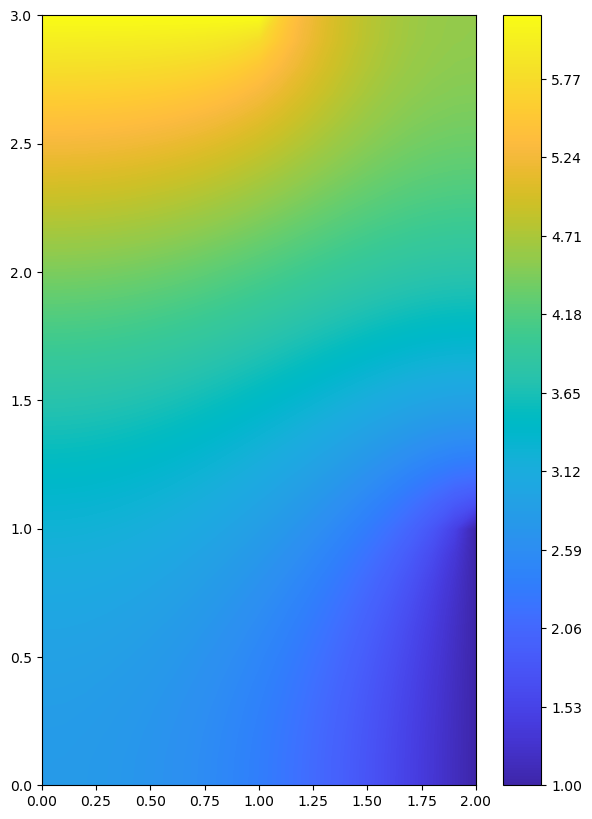


Time 0.5
Iteration #0001, error L2 relative psi:    0.00000798691400


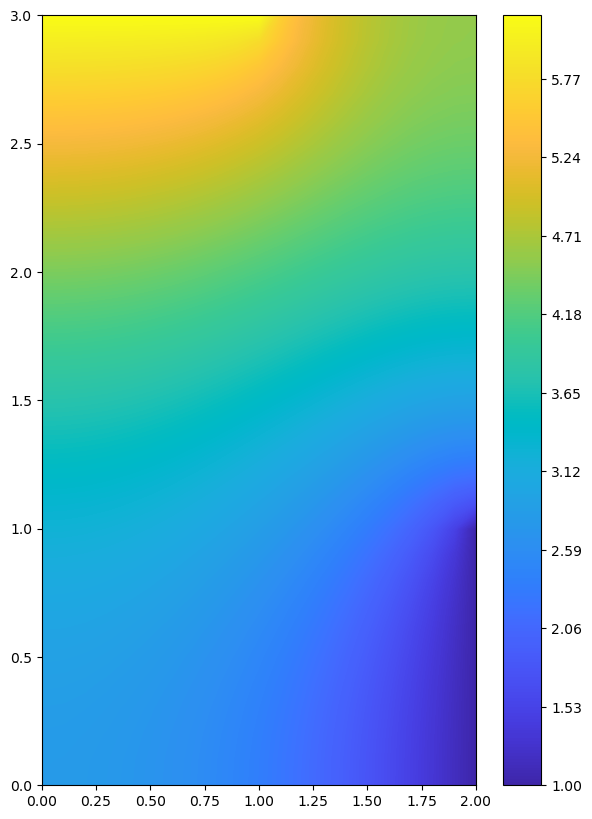


Time 0.52083
Iteration #0001, error L2 relative psi:    0.00000777643526


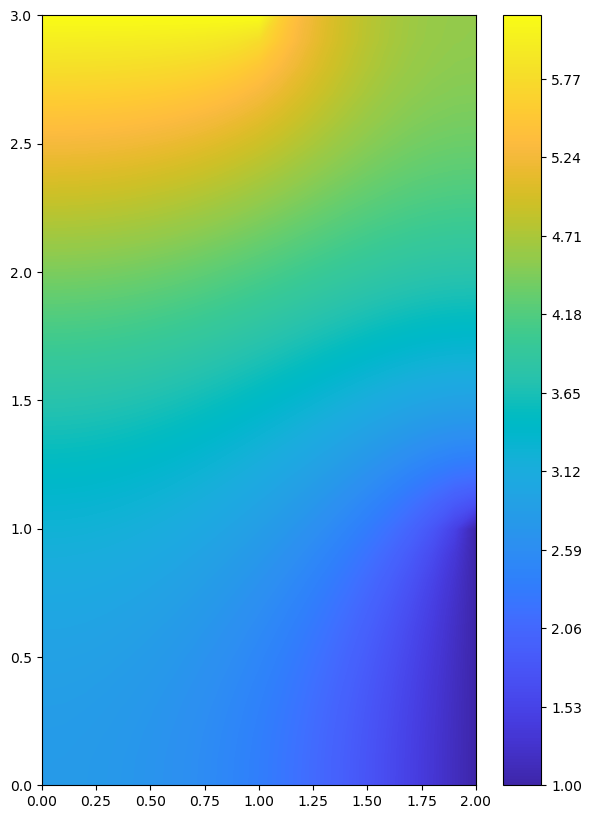


Time 0.54167
Iteration #0001, error L2 relative psi:    0.00000757150411


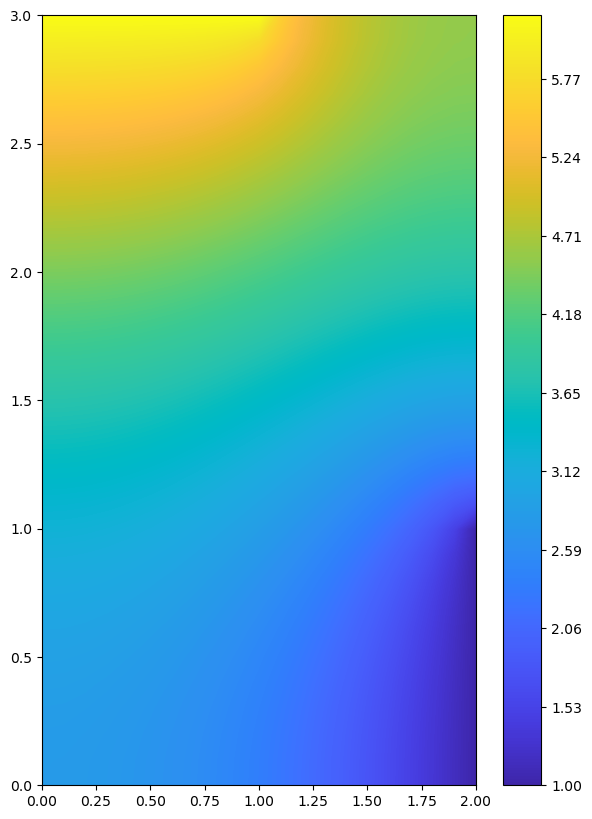


Time 0.5625
Iteration #0001, error L2 relative psi:    0.00000737197429


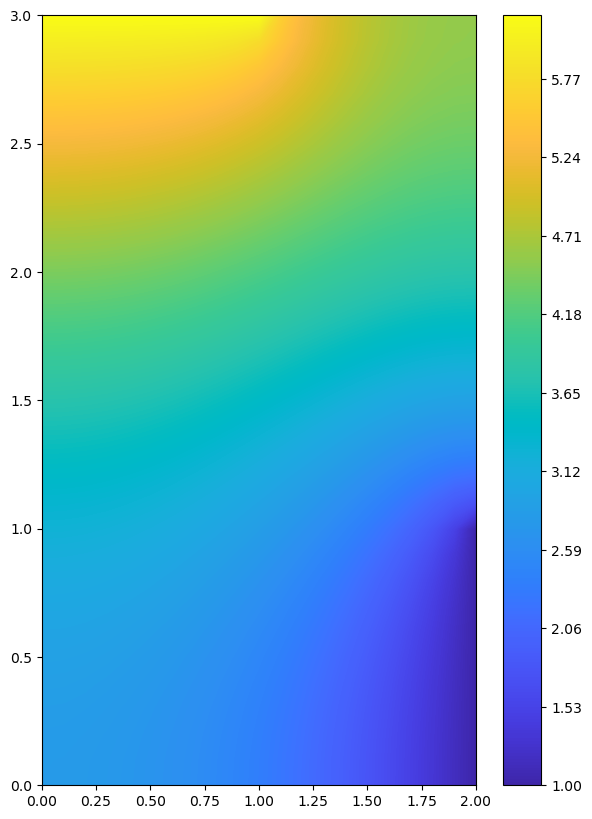

In [37]:
# Time Loop
for step in range(1, ceil(T/dt) + 1):
    current_time = step * dt
    print('Time ' + str(round(current_time, 5)))
    
    time_rhs = np.zeros_like(sol[-1])

    time_rhs[top_mask] += top_mass @ model_data.theta(sol[-1][top_mask], 1 + top_grid.nodes[1,:]) / dt

    prev = sol[-1]

    for k in range(K):
        rhs = time_rhs.copy()

        rhs[top_mask] += L * top_mass @ prev[top_mask] / dt
        rhs[top_mask] -= top_mass @ model_data.theta(prev[top_mask], 1 + top_grid.nodes[1,:]) / dt

        bottom_mat = bottom_stifness
        top_stifness = top_stifness_gen(prev[top_mask])

        top_mat = top_stifness + L / dt * top_mass
        top_vel = top_normal_continuity_matrix(prev[top_mask])

        spp = sps.bmat([[                 bottom_mat,                      None, bottom_isolate_boundary_dof.T],
                        [                       None,                   top_mat,   -top_isolate_boundary_dof.T],
                        [bottom_isolate_boundary_dof, -top_isolate_boundary_dof,                          None]], format='csc')
        
        ls = pg.LinearSystem(spp, rhs)

        #print(spp, rhs)

        ls.flag_ess_bc(dirichlet_flag, dirichlet_value(current_time))

        current = ls.solve()

        # Check if we have reached convergence
        rel_err_psi  = np.sqrt( (current - prev).T @ (current - prev) )
        abs_err_prev = np.sqrt( prev.T @ prev )

        # Log message with error and current iteration
        print('Iteration #' + format(k+1, '0' + str(ceil(log10(K)) + 1) + 'd') + ', error L2 relative psi: ' 
              + format(rel_err_psi / abs_err_prev, str(5 + ceil(log10(1 / abs_tol)) + 4) + '.' + str(ceil(log10(1 / abs_tol)) + 4) + 'f') )
        
        if rel_err_psi > abs_tol + rel_tol * abs_err_prev:
            prev = current.copy()
        else:
            break

    sol.append( current )

    save_step(sol[-1], step)
    print('')    